# Graphical representations of sparse-search concepts

In [10]:
import numpy as np

from scipy.stats import mvn
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Indexing documents

The cost of indexing is determined by the cost of the transform (later) and the cost of storage.  For us, this is represented as the sparsity of the transformed vector.

In the case of the Gaussian matrix transform, sparsity is determined by
\begin{equation}
    \mathbb{E}k = m\mathbb{P}(N>h)
\end{equation}
where $N\sim{\cal N}(0, 1)$.

We choose $h=\sqrt{2r\log m}$.  This represents a compromise as $m\rightarrow\infty$:

* The score, $S(x,y)$, remains sensitive to $\lambda = x^T y$ for large $m$
* The transformed vectors $Ax$ remain sparse for large $m$

Parameter $0<r<1$ determines the rate at which sparsity grows and error shrinks with $m$.  That is, $m$ and $r$ jointly determine the sparsity and error of our search scheme.

In [176]:
def sparsity(m, r):
    return m*norm.sf(np.sqrt(2.*r*np.log(m)))

def asymptotic_sparsity(m, r):
    # assumes h>1 or so
    return (m**(1.-r))/np.sqrt(2.*np.pi*np.log(m))

def h(m, r):
    return np.sqrt(2.*r*np.log(m))

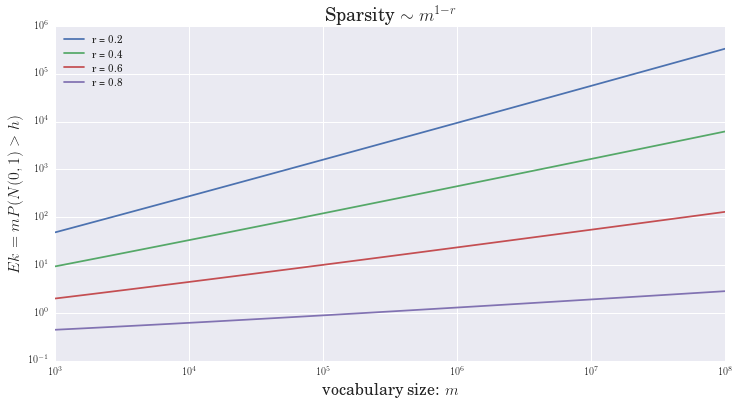

In [177]:
m = np.logspace(3, 8, 100)
r = np.array([0.2, 0.4, 0.6, 0.8])

plt.rc('font', family='serif', size=16)

plt.figure(num=None, figsize=(12, 6))

for k, r_ in enumerate(r):
    f = [sparsity(x, r_) for x in m]
    plt.loglog(m, f, label="r = {}".format(r_))

plt.title("Sparsity $\sim m^{1-r}$", fontsize=18)
plt.xlabel(r"vocabulary size: $m$", fontsize=16)
plt.ylabel(r'$\mathbb{E}k = m \mathbb{P} ( N(0,1)  > h )$', fontsize=16)
plt.legend(loc='upper left')

plt.show()

## Expected score

We compute the score from integrating the analytic derivative of the expected score
\begin{equation}
    \frac{d\mu}{d \lambda} = \frac{1}{2\pi\sqrt{1-\lambda^2}}\exp\bigg(-\frac{h^2}{1+\lambda}\bigg)
\end{equation}

In [187]:
def dmu(t, h):
    return np.exp(-h**2/(1.+t))/(2.*np.pi*np.sqrt(1.-t**2))

def mu(t, h):
    return quad(lambda x: dmu(x, h), 0., t)[0] + (1. - norm.cdf(h))**2

def sigma(t, r, m):
    mu_ = mu(t, np.sqrt(2.*r*np.log(m)))
    return np.sqrt(mu_*(1-mu_)/m)

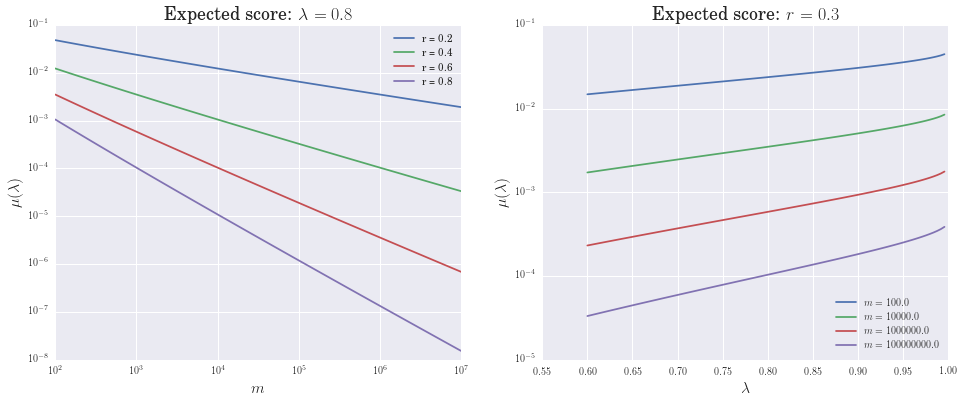

In [175]:
m = np.logspace(2, 7, 100)

l = np.linspace(0.6, 1.0, 100)[:-1]
r = np.array([0.2, 0.4, 0.6, 0.8])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

lambda_ = 0.8
for r_ in r:    
    f = [mu(lambda_, np.sqrt(2.*r_*np.log(m_))) for m_ in m]
    axs[0].loglog(m, f, label="r = {}".format(r_))

axs[0].set_title("Expected score: $\lambda = {}$".format(lambda_), fontsize=18)
axs[0].set_xlabel("$m$", fontsize=16)
axs[0].set_ylabel("$\mu(\lambda)$", fontsize=16)
axs[0].legend(loc='best')

r_ = 0.3
for m_ in [1e2, 1e4, 1e6, 1e8]:
    f = [mu(l_, np.sqrt(2.*r_*np.log(m_))) for l_ in l]
    axs[1].semilogy(l, f, label="$m = {}$".format(m_))

axs[1].set_title("Expected score: $r = {}$".format(r_), fontsize=18)
axs[1].set_xlabel("$\lambda$", fontsize=16)
axs[1].set_ylabel("$\mu(\lambda)$", fontsize=16)
axs[1].legend(loc='best')

plt.show()

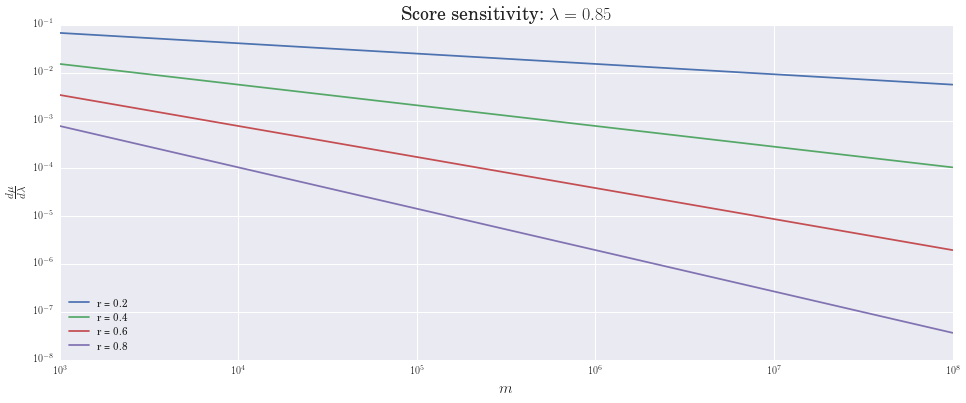

In [186]:
m = np.logspace(3, 8, 100)
r = np.array([0.2, 0.4, 0.6, 0.8])

fig, axs = plt.subplots(figsize=(16, 6))

lambda_ = 0.85
for r_ in r:    
    f = [dmu(lambda_, np.sqrt(2.*r_*np.log(m_))) for m_ in m]
    axs.loglog(m, f, label="r = {}".format(r_))

axs.set_title("Score sensitivity: $\lambda = {}$".format(lambda_), fontsize=18)
axs.set_xlabel("$m$", fontsize=16)
axs.set_ylabel(r"$\frac{d\mu}{d\lambda}$", fontsize=16)
axs.legend(loc='best')

plt.show()

## Document retrieval

Set $\mu(\lambda)$ our threshold for retrieval, returning a document if and only if its score exceeds this threshold.
Choose a tolerance $\epsilon$, and regard documents with $x^Ty < \lambda-\epsilon$ as non-relevant.
> Type I error: falsely accept (retrieve) a non-relevant document
\begin{equation}
    \alpha = \mathbb{P}\bigg(\text{score}\big( x, y \,\big|\,x^T y = \lambda-\epsilon \big) >\mu(\lambda)\bigg)
\end{equation}

Similarly, if we regard documents $x^T y > \lambda+\epsilon$ as relevant, we have
> Type II error: falsely reject (fail to retrieve) a relevant document
\begin{equation}
    \beta = \mathbb{P}\bigg(\text{score}\big( x, y \,\big|\,x^T y = \lambda+\epsilon \big) <\mu(\lambda)\bigg)
\end{equation}

(This isn't quite right:  I wonder if we should change this framework slightly, setting $\mu(\lambda)$ our threshold for *relevancy* rather than retrieval.)

In [188]:
def alpha_zscore(lambda_, r, m, epsilon):
    h = np.sqrt(2.*r*np.log(m))
    return (mu(lambda_, h)-mu(lambda_-epsilon, h))/sigma(lambda_-epsilon, r, m)

def epsilon_lower(m, lambda_, r, alpha):
    return fsolve(lambda x: alpha_zscore(lambda_, r, m, x)-norm.isf(alpha), 0.1, full_output=False)[0]

def beta_zscore(lambda_, r, m, epsilon):
    return alpha_zscore(lambda_, r, m, -epsilon)

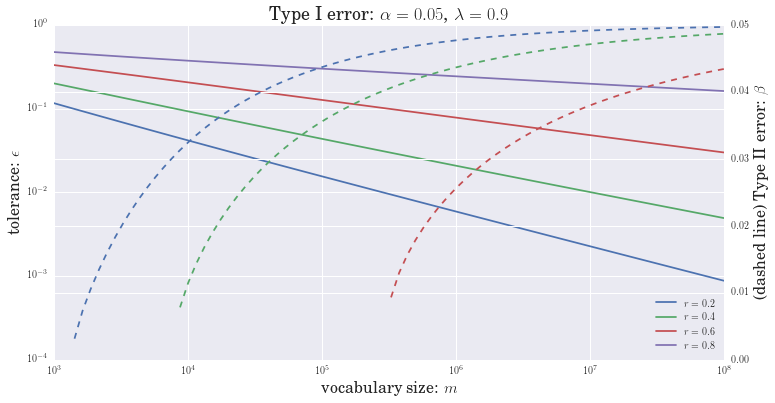

In [167]:
lambda_ = 0.9
alpha = 0.05

m = np.logspace(2, 8, 100)
r = np.array([0.2, 0.4, 0.6, 0.8])

plt.rc('font', family='serif', size=16)

fig, ax_left = plt.subplots(figsize=(12, 6))
ax_left.set_xlabel(r'vocabulary size: $m$', fontsize=16)
ax_left.set_ylabel(r'tolerance: $\epsilon$', fontsize=16)
ax_left.set_title(r'Type I error: $\alpha = {}$, $\lambda = {}$'.format(alpha, lambda_), fontsize=18)

ax_right = ax_left.twinx()
ax_right.set_ylabel(r'(dashed line) Type II error: $\beta$', fontsize=16)

for k, r_ in enumerate(r):
    f1 = [epsilon_lower(x, lambda_, r_, alpha) for x in m]
    ax_left.loglog(m, f1, label="$r = {}$".format(r_))
    
    f2 = [norm.cdf(beta_zscore(lambda_, r_, x, eps)) for x, eps in zip(m, f1)]
    ax_right.semilogx(m, f2, '--')

ax_left.legend(loc='lower right')

plt.show()

Note that Type II error becomes tiny when it becomes impossible for relevant documents to exist (when $\lambda+\epsilon >= 1$).

## Epsilon 

say something

In [5]:
def dmu(t, h):
    return np.exp(-h**2/(1.+t))/(2.*np.pi*np.sqrt(1.-t**2))

def mu_of_h(t, h):
    return quad(lambda x: dmu(x, h), 0., t)[0] + (1. - norm.cdf(h))**2

def mu(m, r, lambda_):
    h = np.sqrt(2*r*np.log(m))
    mu_, _ = mvn.mvnun([-10**5, -10**5], [-h,-h], [0,0], [[1,lambda_],[lambda_,1]])
    return mu_

def val(eps, m, r, eta, lambda_,):
    mu_lambda_eps = mu(m, r, lambda_-eps)
    val_ = (mu(m, r, lambda_)-mu_lambda_eps)*np.sqrt(m)/np.sqrt(mu_lambda_eps*(1-mu_lambda_eps))/eta
    return val_
    
def eps(m, r, eta, lambda_, choice):
    h = np.sqrt(2*r*np.log(m))
    
    if choice == 1:
        C = np.sqrt(2*np.pi*(1+lambda_)**2*np.sqrt(1-lambda_**2))*eta/h
        eps_ = C*np.exp(h**2/(2*(1+lambda_)))/np.sqrt(m)
        
    elif choice ==2:
        actual_deriv = 1/(2*np.pi*np.sqrt(1-lambda_**2))*np.exp(-h**2/(1+lambda_))
        mu_ = mu(m, r, lambda_)
        eps_ = eta*np.sqrt(mu_*(1-mu_))/actual_deriv/np.sqrt(m)
        
    elif choice ==3:
        tol = 10**-6
        eps_ = eps(m, r, eta, lambda_, 2)
        max_, min_ = eps_*4, eps_/4
        error = 2*tol
        
        while error > tol:
            current_val = val(eps_, m, r, eta, lambda_)
            if current_val > 1:
                max_ = eps_
            else:
                min_ = eps_
            error = abs(current_val-1)
            eps_ = (max_+min_)/2
            
    return eps_

In [6]:
from scipy.optimize import brentq

def f_of_epsilon_minus(eps_minus, m, r, eta, lambda_):
    ''' objective to solve for non-asymptotic eps^- in (3.8)
        of paper
    '''
    mu_lambda = mu(m, r, lambda_)
    mu_lambda_eps = mu(m, r, lambda_-eps_minus)
    sigma = np.sqrt(mu_lambda_eps*(1.-mu_lambda_eps))    
    return np.sqrt(m)*(mu_lambda - mu_lambda_eps)/sigma - eta

def f_of_epsilon_plus(eps_plus, m, r, eta, lambda_):
    ''' objective to solve for non-asymptotic eps^+ in (3.8)
        of paper
    '''
    mu_lambda = mu(m, r, lambda_)
    mu_lambda_eps = mu(m, r, lambda_+eps_plus)
    sigma = np.sqrt(mu_lambda_eps*(1.-mu_lambda_eps))    
    return np.sqrt(m)*(mu_lambda - mu_lambda_eps)/sigma + eta

def epsilon_minus(m, r, eta, lambda_):
    try:
        return -brentq(f_of_epsilon_minus, a=0.0, b=1.0, args=(m, r, eta, lambda_,))
    except ValueError:
        return -lambda_
    
def epsilon_plus(m, r, eta, lambda_):
    try:
        return brentq(f_of_epsilon_plus, a=0.0, b=1.0, args=(m, r, eta, lambda_,))
    except ValueError:
        return 1.0-lambda_

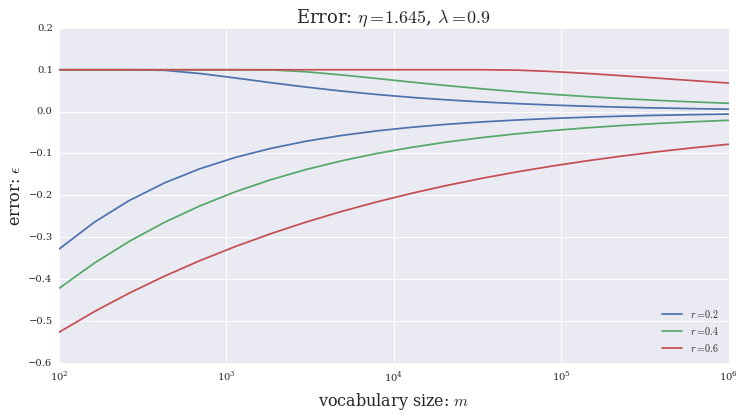

In [13]:
lambda_=0.9
r=[0.2, 0.4, 0.6]
m=np.logspace(2, 6, 20)
eta = 1.645

plt.rc('font', family='serif', size=16)
fig,ax = plt.subplots(figsize=(12, 6))
sns.set_style('darkgrid')
ax.set_xlabel(r'vocabulary size: $m$', fontsize=16)
ax.set_ylabel(r'error: $\epsilon$', fontsize=16)
ax.set_title(r'Error: $\eta = {}$, $\lambda = {}$'.format(eta, lambda_), fontsize=18)

eps_plus = []
eps_minus = []

palette = sns.color_palette("deep", len(r))

for k, r_ in enumerate(r):
    eps_plus.append([epsilon_plus(m_, r_, eta, lambda_) for m_ in m])
    ax.semilogx(m, eps_plus[k], '-', color = palette[k], label="$r = {}$".format(r_))
    
    eps_minus.append([epsilon_minus(m_, r_, eta, lambda_) for m_ in m])
    ax.semilogx(m, eps_minus[k],  '-', color = palette[k])

    
ax.legend(loc='best') 
ax.set_title(r'Error: $\eta = {}$, $\lambda = {}$'.format(eta, lambda_), fontsize=18)

plt.show()